## Laboratorio 2 - Luis Epifanio

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
from bs4 import BeautifulSoup

from nltk.tokenize import WordPunctTokenizer

from sklearn.dummy import DummyClassifier
from sklearn.datasets import load_files
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import seaborn as sns

import string
from time import time
import re

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Cargamos los datos y dividimos en entrenamiento y validacion

In [37]:
#from utils import load_datasets_unlabeled_test
#train, dev, test = load_datasets_unlabeled_test()
#X_train, y_train = train
#X_dev, y_dev = dev
#X_test, y_test = test
dataset = load_files('./review_polarity_competition/reviews_sentoken', shuffle=False)
X_train, X_dev, y_train, y_dev = train_test_split(
    dataset.data,
    dataset.target,
    test_size=0.25,
    random_state=42
)

In [38]:
print( 'Train      dataset has {} elements and resolution of {:.2f}%'.format( len(X_train) , ( 1 / len(X_train) ) * 100 ) )
print( 'Validation dataset has {} elements and resolution of {:.2f}%'.format( len(X_dev) , ( 1 / len(X_dev) ) * 100 ) )
#print( 'Test       dataset has {} elements and resolution of {:.2f}%'.format( len(test) , ( 1 / len(test) ) * 100 ) )

Train      dataset has 802 elements and resolution of 0.12%
Validation dataset has 268 elements and resolution of 0.37%


## Tratamos de jugar limpiando algunos patrones
Finalmente esto parece haber influido en como evaluar el conjunto de pruebas, de ahi que lo veamos deshabilitado

the breakfast club entertaining it is not el dorado has 12 values
TRAIN


,text,target
0,"b""WHAT IS HOLLYWOOD 'S PROBLEM , ANYWAY ? THIS IS THE GREATEST FILM EVER MADE . Okay , maybe I do n't honestly believe that . Maybe `` The Cable G...",1
1,"b""This movie empitomizes cheezy horror ! Mooselini 's character was hilarious . Nothing beats the heads flying ! 2 points for this movie ! ! It 's...",1
2,"b""If you do n't have a multisystem TV and DVD player to utilize PAL , you can use a computer , PC with a DVD program or Mac to watch DVDs that you...",0
3,"b""I rented `` 28 Days '' with no expectations , and was impressed . Good action , suspenseful and plot . 28 weeks , however , does not live up as ...",0
4,"b""Starting in the late 50 's , there was a string of country music movies made , perhaps in reaction to the successful string of B rock and roll m...",1


1    0.514963
0    0.485037
Name: target, dtype: float64

VALIDATION


,text,target
0,"b""In this dvd you have , the Boston POPS orchestra with it 's truly fantastic conductor , Keith Lockhart , Elmo and the Sesame Street gang , and t...",1
1,"b'This show is the best . I was slow to get into it , but now every thursday night I am glued to the TV waiting eagerly for the Office theme song ...",1
2,"b""I have a couple of the Lucy collections , and they are a lot of fun ; however , they are random selections and Lucy 's work deserves complete , ...",0
3,"b""A Better Way To Die is a action-packed , dark-comedy about a ex-chicago-cop named `` Boomer '' who quits the force after his partner is killed i...",1
4,"b""This is an unusual Merchant/Ivory film that focuses on the Indian community of Trinidad from 1943 to about 1954 . It focuses in particular upon ...",1


0    0.544776
1    0.455224
Name: target, dtype: float64

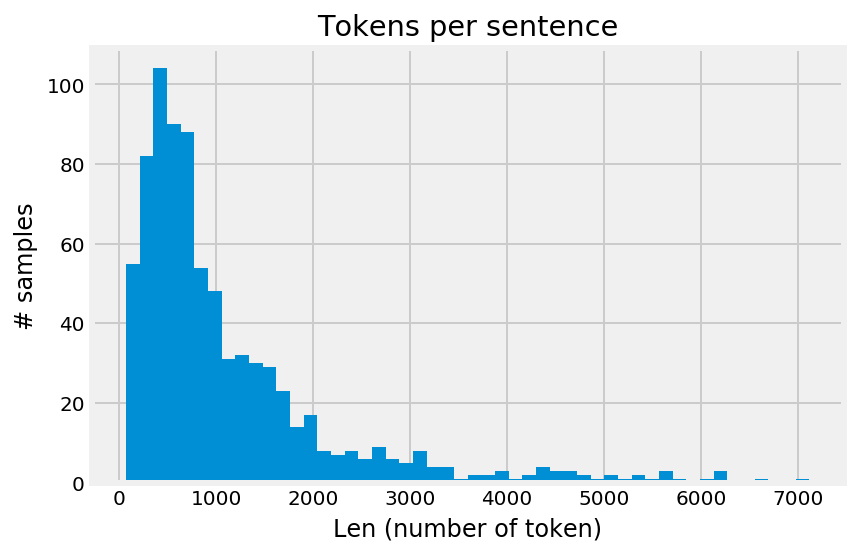

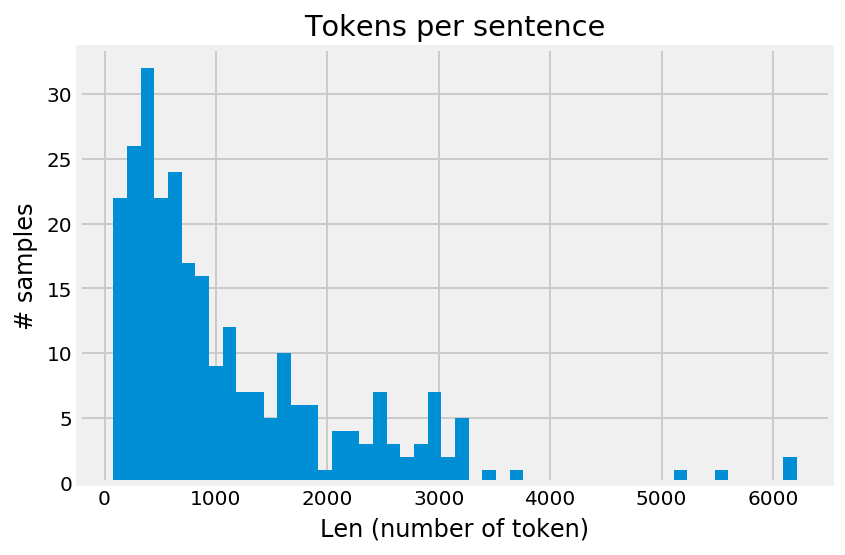

In [39]:

tok = WordPunctTokenizer()

quote = r'& quot ;'
htmlent = r'& .{2,5} ;'
combinedPattern = r'|'.join((quote, htmlent))

#Weird "isn't" -> "is n't" convertion so will revert manually this pattern 
negations_dic = {
    "is n't": "is not",
    "are n't": "are not",
    "was n't": "was not",
    "were n't": "were not",
    "have n't": "have not",
    "has n't": "has not",
    "had n't": "had not",
    "wo n't": "will not",
    "would n't": "would not",
    "do n't": "do not",
    "does n't": "does not",
    "did n't": "did not",
    "ca n't": "can not",
    "could n't": "could not",
    "should n't": "should not",
    "might n't": "might not",
    "must n't": "must not"
}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def cleanText(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combinedPattern, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], clean)
    letters_only = re.sub("[^a-zA-Z0-9]", " ", neg_handled)
    lower_case = letters_only.lower()
    punct_handled =  re_tok.sub(r' \1 ', lower_case)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(punct_handled)
    return (" ".join(words)).strip()

demo = "& quot ; The Breakfast Club & quot ; Entertaining it is n't . `` El Dorado '' has 12 values"
print(cleanText(demo))



#X_train = [ cleanText(text) for text in X_train ]
#X_dev   = [ cleanText(text) for text in X_dev   ]
#display(X_train)

trainDf = pd.DataFrame({'text': X_train , 'target': y_train })
valDf   = pd.DataFrame({'text': X_dev   , 'target': y_dev   })

with pd.option_context('display.max_colwidth', 150 ):
    print('TRAIN')
    display( trainDf.head() )
    display( trainDf.target.value_counts(normalize=True) )
    print('VALIDATION')
    display( valDf.head() )
    display( valDf.target.value_counts(normalize=True) )


# Plot sentence by lenght
plt.hist([len(cleanText(s)) for s in trainDf['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

# Plot sentence by lenght
plt.hist([len(cleanText(s)) for s in valDf['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

Como podemos ver la distribucion entre conjuntos parece seguir el mismo criterio

## Preparamos algunas visualizaciones del conjunto de datos a fin de dar soporte a alguna feature en particular

In [40]:
countVectorizer = CountVectorizer()
countVectorizer.fit(trainDf.text)

print( 'Complete space of features has {:d} length'.format( 
        len( countVectorizer.get_feature_names() ) 
    )
)

Complete space of features has 14657 length


In [41]:
neg_doc_matrix = countVectorizer.transform(trainDf[trainDf.target == 0].text)
pos_doc_matrix = countVectorizer.transform(trainDf[trainDf.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=countVectorizer.get_feature_names()).transpose()

term_freq_df.rename(
    columns={
        0: 'negative',
        1: 'positive'
    }, 
    inplace = True
)

#term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']

term_freq_df[1005:1015]

,negative,positive,total
assault,0,1,1
assaulted,0,1,1
assaults,0,1,1
assembled,0,3,3
assembling,0,1,1
asses,1,0,1
assessed,1,0,1
assignment,0,3,3
assist,0,2,2
assistance,0,2,2


## Acaso no parece la *Ley de Zipf*?

### Realizamos un analisis de distribucion

In [8]:
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,3833,6020,9853
and,1733,3131,4864
of,1592,2591,4183
to,1567,2332,3899
is,1339,2059,3398
it,1218,1499,2717
in,912,1666,2578
this,1107,1274,2381
that,881,1193,2074
with,531,829,1360


Text(0.5,1,'Top 150 tokens in movie review')

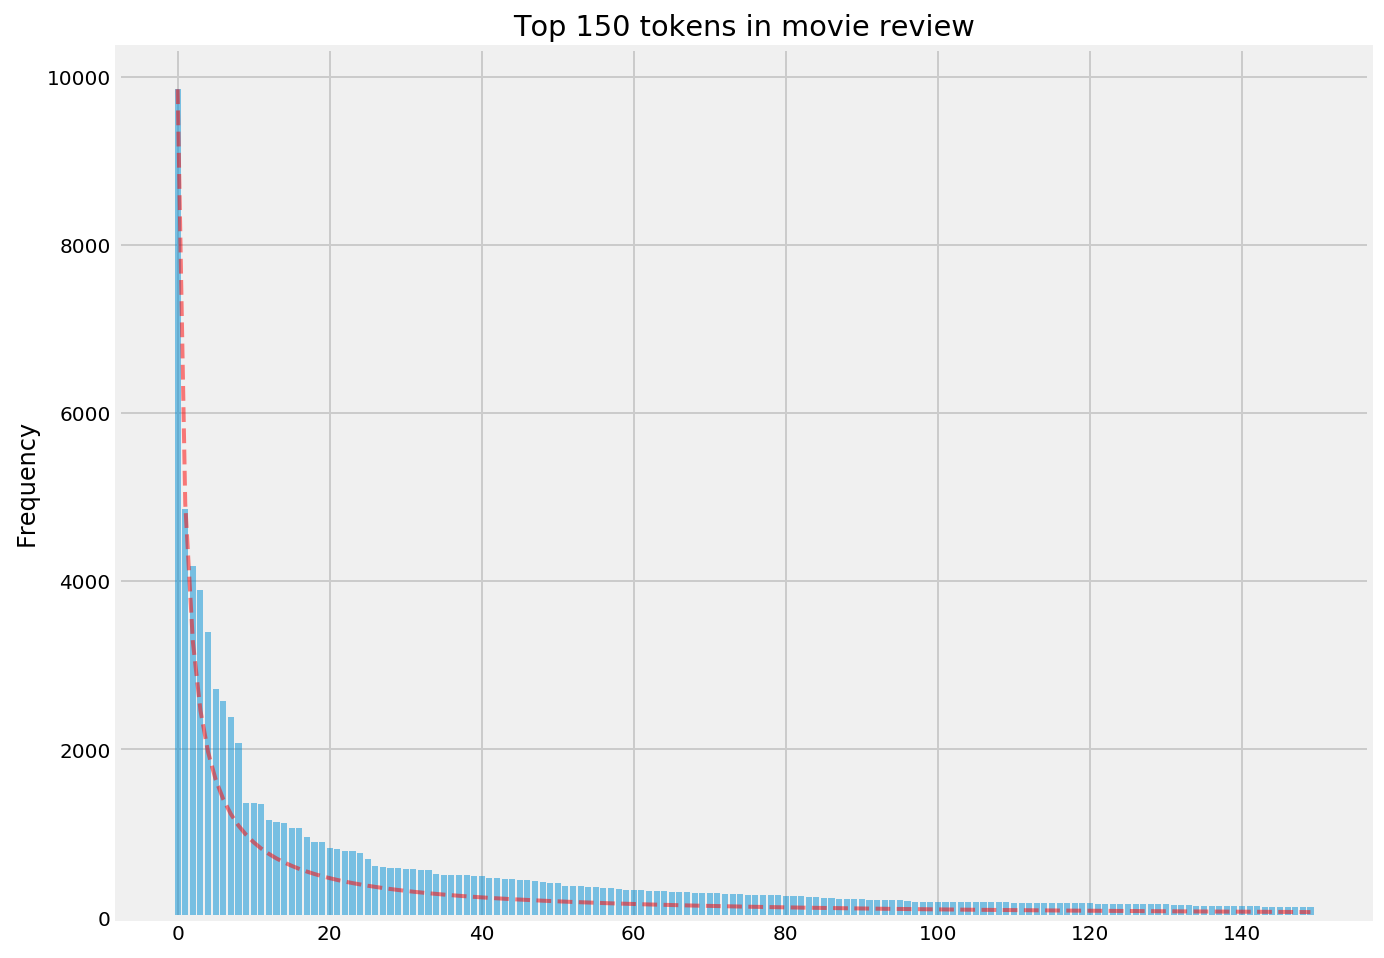

In [9]:
y_pos = np.arange(150)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:150], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 150 tokens in movie review')

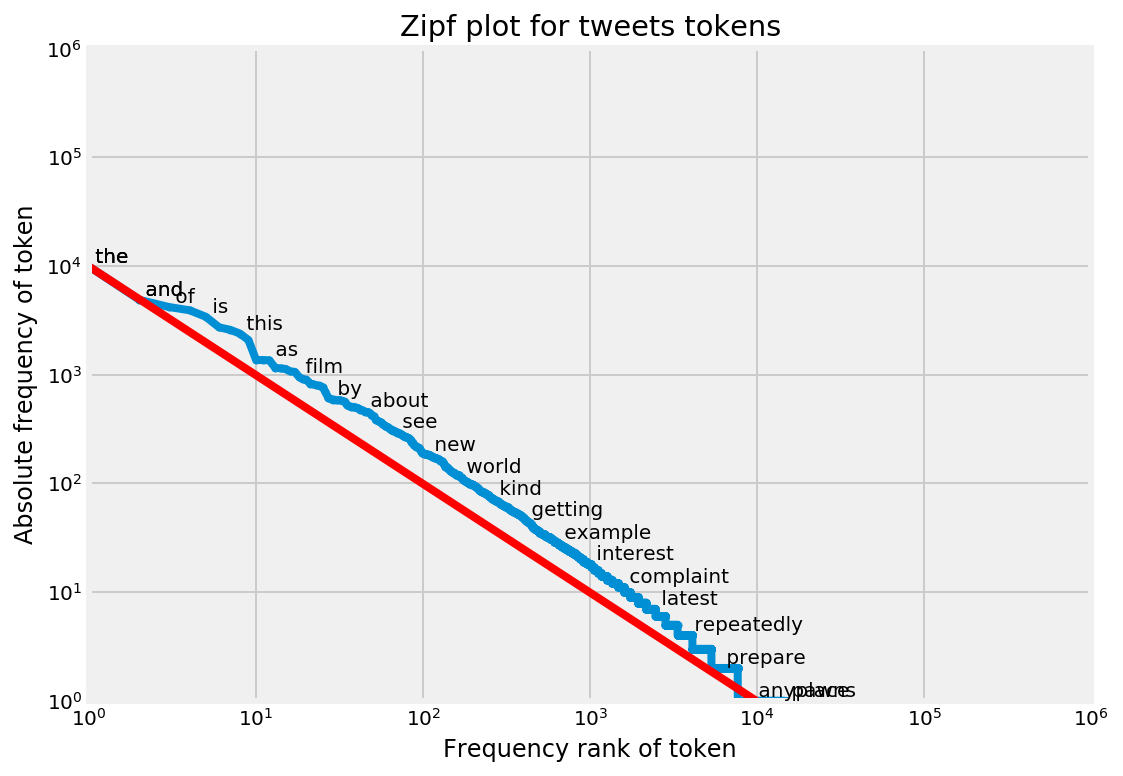

In [10]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

#### Visualizamos el espacio de feature ( para casos positivos y negativos )

In [11]:
countVectorizer = CountVectorizer(stop_words='english',max_features=10000)
countVectorizer.fit(trainDf.text)

print( 'Complete space of features has {:d} length'.format( 
        len( countVectorizer.get_feature_names() ) 
    )
)

Complete space of features has 10000 length


In [12]:
neg_doc_matrix = countVectorizer.transform(trainDf[trainDf.target == 0].text)
pos_doc_matrix = countVectorizer.transform(trainDf[trainDf.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df2 = pd.DataFrame([neg,pos],columns=countVectorizer.get_feature_names()).transpose()

term_freq_df2.rename(
    columns={
        0: 'negative',
        1: 'positive'
    }, 
    inplace = True
)

term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]


,negative,positive,total
movie,558,580,1138
film,286,672,958
dvd,319,266,585
like,229,264,493
just,218,254,472
good,160,221,381
time,131,242,373
great,91,248,339
really,126,179,305
does,138,155,293


#### Let's see what are the top 50 words in negative reviews on a bar chart.

Text(0.5,1,'Top 50 tokens in reviews')

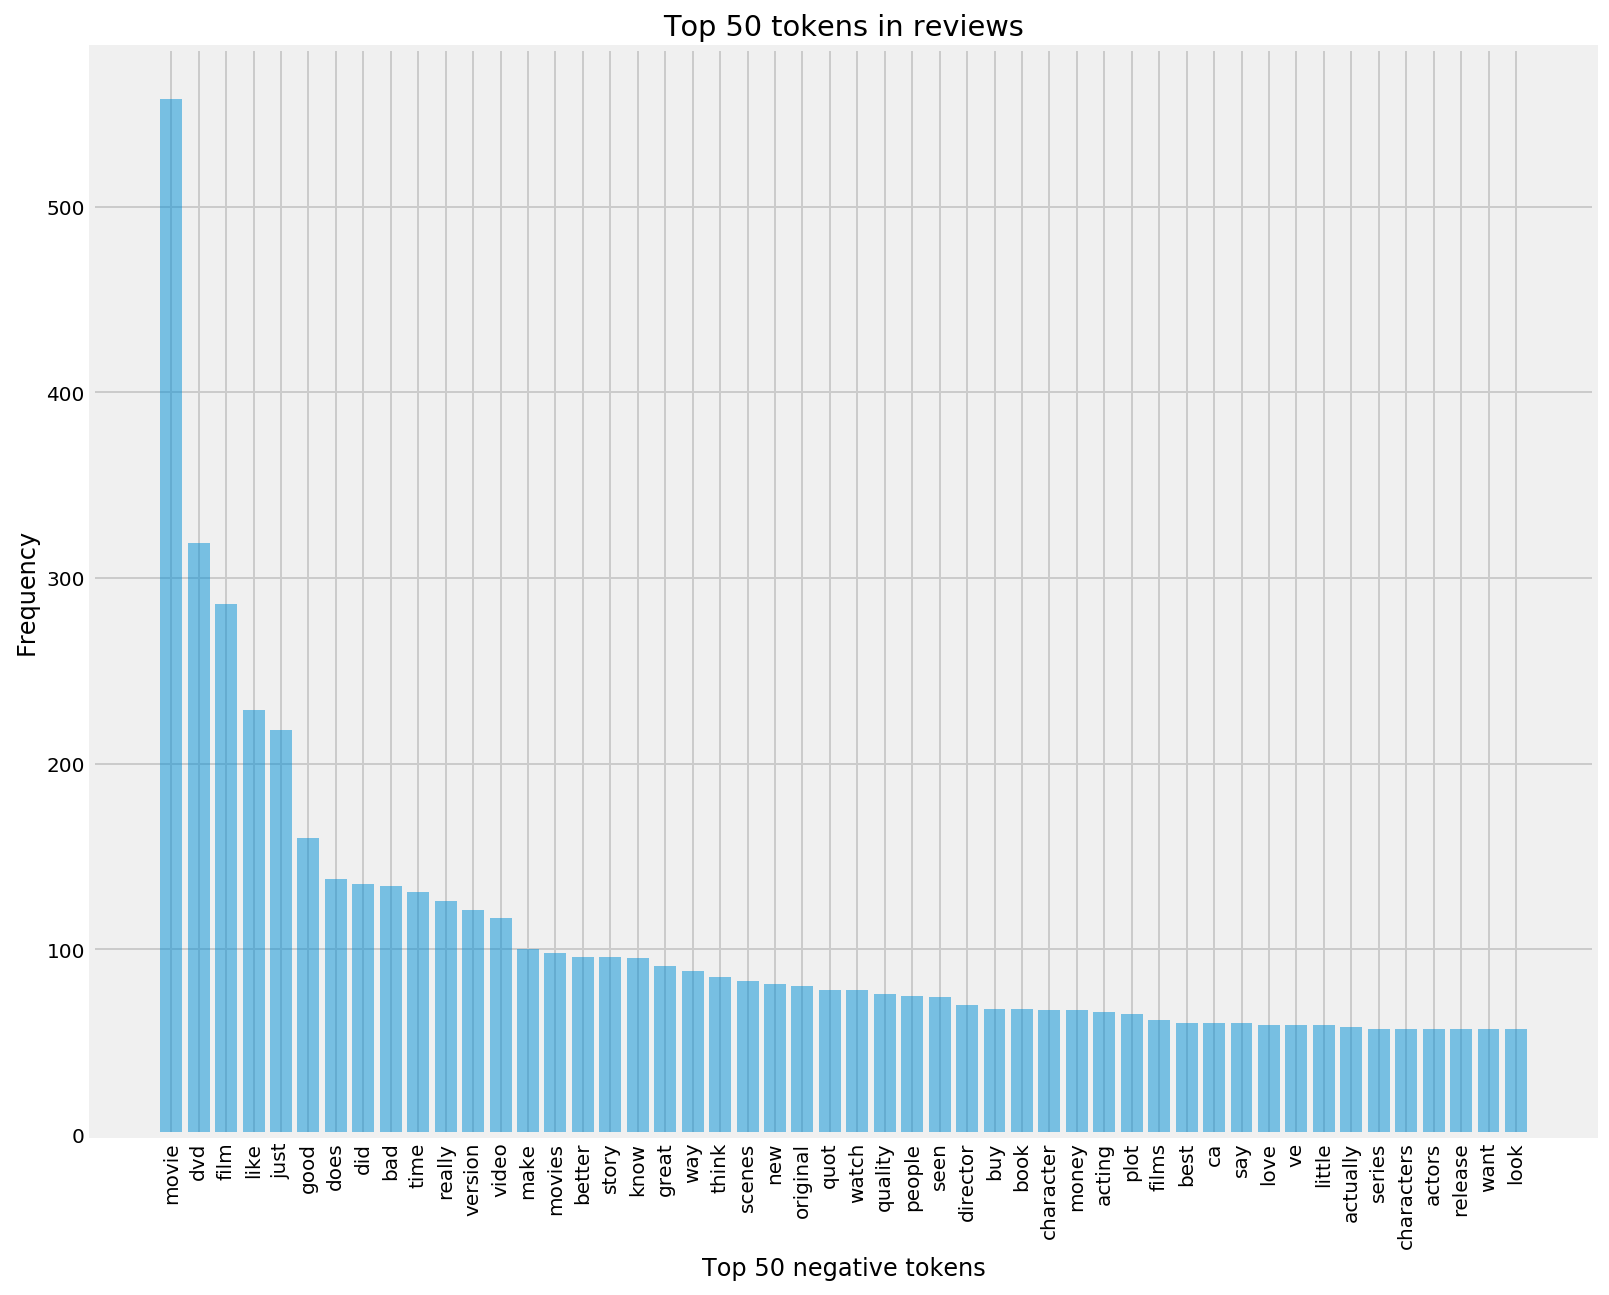

In [13]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in reviews')

#### And what about the top 50 words in positive reviews on a bar chart.

Text(0.5,1,'Top 50 tokens in positive reviews')

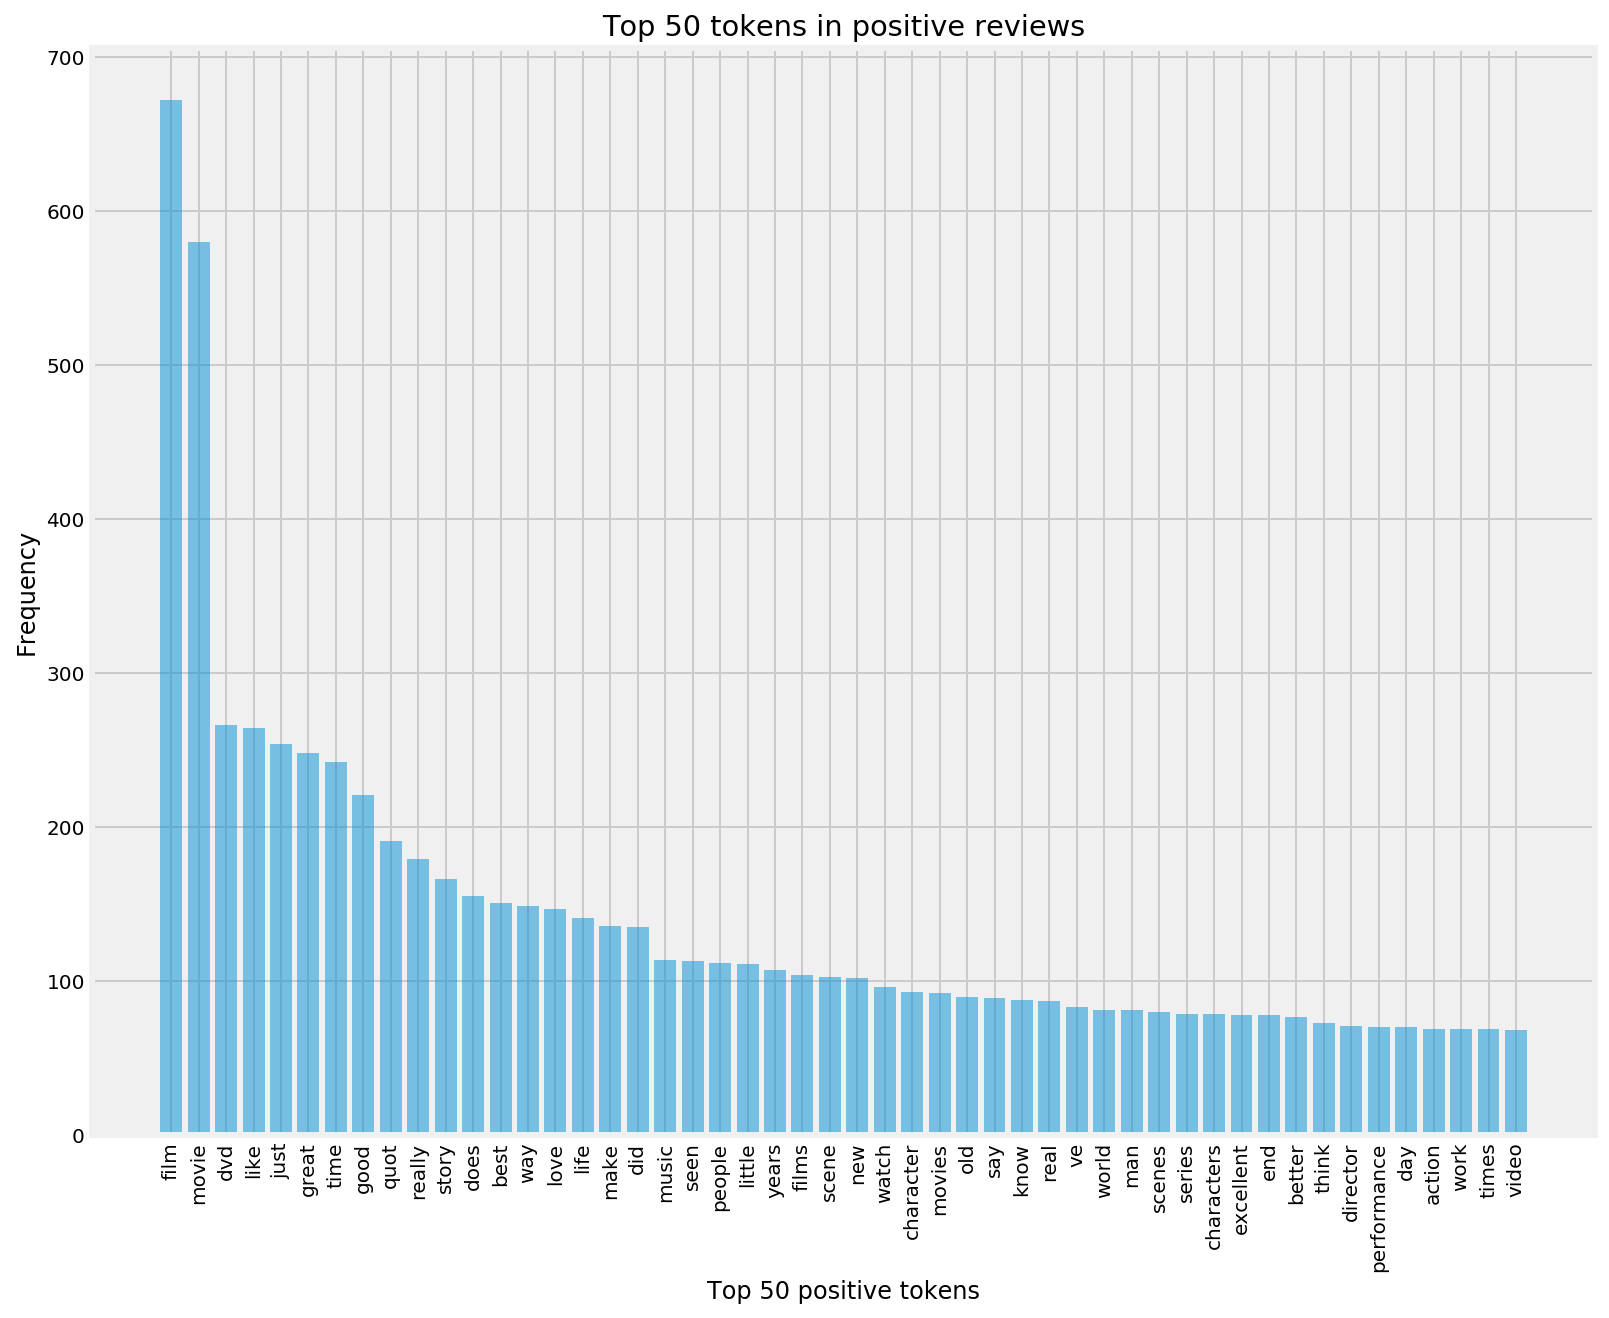

In [14]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive reviews')

Existen algunas palabras como "movie", "film" even "dvd" que tienen una alta frecuencia en ambas
distribuciones que siendo neutras, no aportan tanta informacion al modelo

### Que tal si graficamos en ambos ejes y tratamos de normalizar estos datos ....

Text(0.5,1,'Negative Frequency vs Positive Frequency')

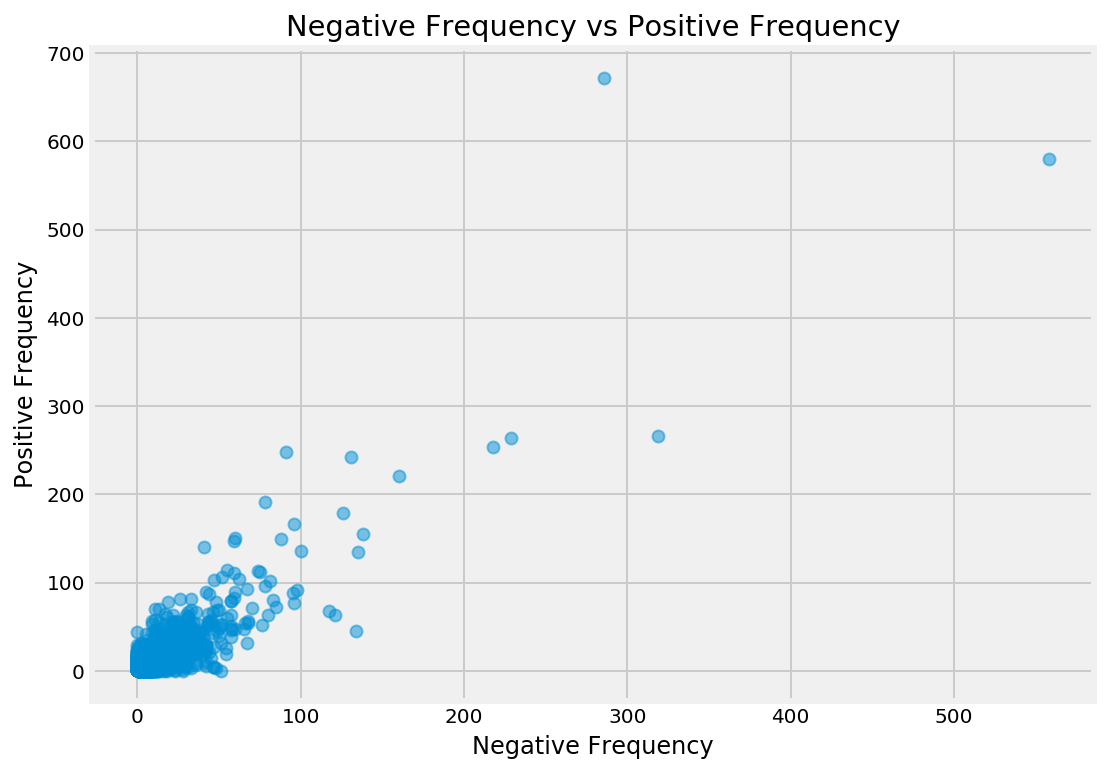

In [15]:

plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [16]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
00,0,2,2,1.0
restaurant,0,2,2,1.0
specials,0,2,2,1.0
responsibility,0,3,3,1.0
dishy,0,2,2,1.0
dish,0,2,2,1.0
restart,0,1,1,1.0
disgusted,0,2,2,1.0
disease,0,3,3,1.0
resolves,0,1,1,1.0


Podemos apreciar que aquellas features con alto ratio positivo tienen casi nulo frecuencia como para tomarlos como indicadores de una review positiva o negativa....esto lo veremos mas abajo

In [17]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
film,286,672,958,0.701461,0.015053
movie,558,580,1138,0.509666,0.012992
dvd,319,266,585,0.454701,0.005959
like,229,264,493,0.535497,0.005914
just,218,254,472,0.538136,0.005690
great,91,248,339,0.731563,0.005555
time,131,242,373,0.648794,0.005421
good,160,221,381,0.580052,0.004950
quot,78,191,269,0.710037,0.004278
really,126,179,305,0.586885,0.004010


podemos realizar el mismo analisis para negativos, con las mismas conclusiones, por tanto trataremos de utilizar una media armonica para ambos valores para luego nomrmalizalos y ver que features aportan mas info al modelo

In [18]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(
    lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
               if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), 
    axis=1
)                                                        
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
film,286,672,958,0.701461,0.015053,0.029474
movie,558,580,1138,0.509666,0.012992,0.025339
dvd,319,266,585,0.454701,0.005959,0.011763
like,229,264,493,0.535497,0.005914,0.011698
just,218,254,472,0.538136,0.005690,0.011260
great,91,248,339,0.731563,0.005555,0.011027
time,131,242,373,0.648794,0.005421,0.010752
good,160,221,381,0.580052,0.004950,0.009817
quot,78,191,269,0.710037,0.004278,0.008506
really,126,179,305,0.586885,0.004010,0.007965


In [19]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
65533,0,44,44,1.000000,0.000986,0.001969,0.830013,0.997080,0.905908
ritchie,0,29,29,1.000000,0.000650,0.001298,0.830013,0.956438,0.888752
caine,0,26,26,1.000000,0.000582,0.001164,0.830013,0.933398,0.878675
local,1,28,29,0.965517,0.000627,0.001254,0.805476,0.949606,0.871623
strong,2,32,34,0.941176,0.000717,0.001433,0.786922,0.972567,0.869951
album,0,23,23,1.000000,0.000515,0.001030,0.830013,0.901893,0.864461
fred,0,23,23,1.000000,0.000515,0.001030,0.830013,0.901893,0.864461
pekar,0,23,23,1.000000,0.000515,0.001030,0.830013,0.901893,0.864461
french,1,26,27,0.962963,0.000582,0.001164,0.803576,0.933398,0.863636
perfect,5,42,47,0.893617,0.000941,0.001880,0.747837,0.995567,0.854101


Same for negative values

In [20]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
boll,51,0,51,0.000000,0.000000,0.000000,0.041013,0.377799,0.073994,1.000000,0.001777,0.003547,0.958987,0.999996,0.979062
uwe,28,0,28,0.000000,0.000000,0.000000,0.041013,0.377799,0.073994,1.000000,0.000975,0.001949,0.958987,0.989912,0.974204
worst,48,3,51,0.058824,0.000067,0.000134,0.056982,0.459342,0.101388,0.941176,0.001672,0.003338,0.943018,0.999985,0.970666
game,47,4,51,0.078431,0.000090,0.000179,0.063280,0.487090,0.112008,0.921569,0.001637,0.003269,0.936720,0.999977,0.967316
waste,46,4,50,0.080000,0.000090,0.000179,0.063806,0.487090,0.112832,0.920000,0.001602,0.003199,0.936194,0.999967,0.967030
terrible,33,3,36,0.083333,0.000067,0.000134,0.064936,0.459342,0.113786,0.916667,0.001150,0.002296,0.935064,0.997326,0.965192
slater,28,2,30,0.066667,0.000045,0.000090,0.059439,0.431791,0.104494,0.933333,0.000975,0.001949,0.940561,0.989912,0.964605
bloodrayne,23,0,23,0.000000,0.000000,0.000000,0.041013,0.377799,0.073994,1.000000,0.000801,0.001601,0.958987,0.968616,0.963777
vampire,23,1,24,0.041667,0.000022,0.000045,0.051887,0.404567,0.091977,0.958333,0.000801,0.001601,0.948113,0.968616,0.958255
product,31,4,35,0.114286,0.000090,0.000179,0.076180,0.487090,0.131754,0.885714,0.001080,0.002157,0.923820,0.995344,0.958249


Text(0.5,1,'neg_normcdf_hmean vs pos_normcdf_hmean')

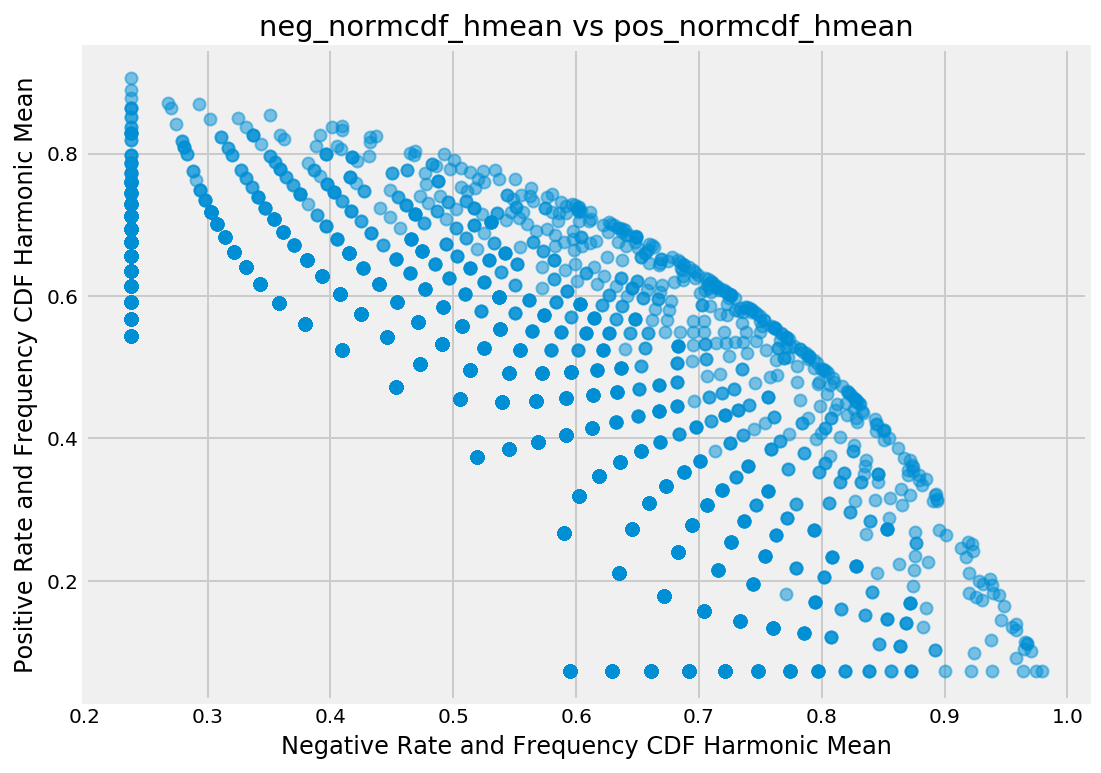

In [21]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [22]:
#from bokeh.plotting import figure
#from bokeh.io import output_notebook, show
#from bokeh.models import LinearColorMapper
#output_notebook()
#color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
#p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
#p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
#from bokeh.models import HoverTool
#hover = HoverTool(tooltips=[('token','@index')])
#p.add_tools(hover)
#show(p)

## Ahora jugamos un poco con algunos Baselines y empezamos a comparar diferentes modelos de clasificadores y vectorizadores

In [23]:
from utils import load_datasets_unlabeled_test
train, dev, test = load_datasets_unlabeled_test()
X_train, y_train = train
X_dev, y_dev = dev

X_train = np.reshape(X_train, (-1, 1))
X_dev = np.reshape(X_dev, (-1, 1))

print( type(X_train) )
print( X_train.shape )

<class 'numpy.ndarray'>
(963, 1)


null accuracy: 54.48%
accuracy score: 82.84%
model is 28.36% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                 127                  19
positive                  27                  95
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.82      0.87      0.85       146
   positive       0.83      0.78      0.81       122

avg / total       0.83      0.83      0.83       268



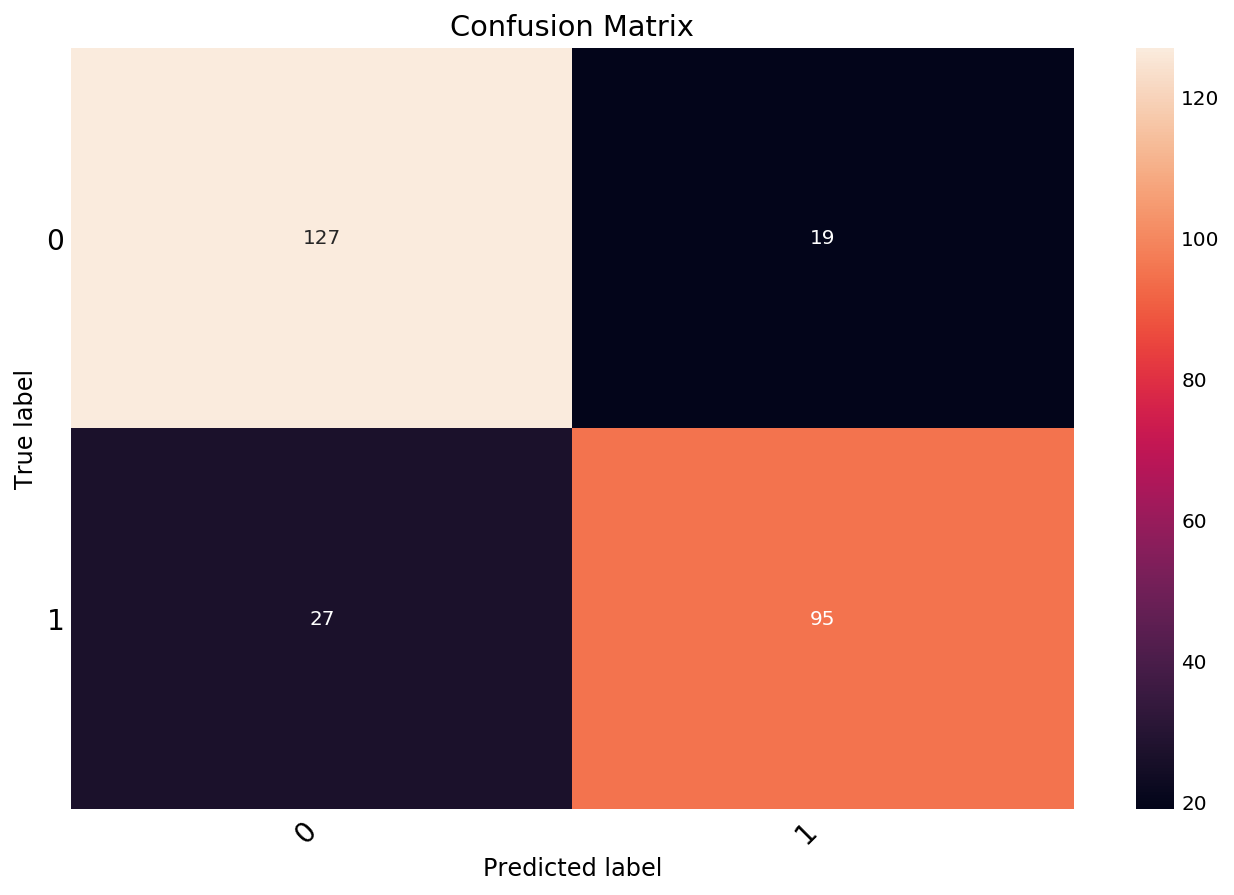

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from utils import train_test_and_evaluate

x_train = trainDf.text
y_train = trainDf.target

x_val = valDf.text
y_val = valDf.target

pipeline = Pipeline([
    ('vect', CountVectorizer(binary=True)),
    ('clf', LogisticRegression(random_state=0)),
])
#pipeline.fit(X_train, y_train)

train_test_and_evaluate(pipeline,x_train,y_train,x_val,y_val)

null accuracy: 54.48%
accuracy score: 81.72%
model is 27.24% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                 115                  31
positive                  18                 104
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.86      0.79      0.82       146
   positive       0.77      0.85      0.81       122

avg / total       0.82      0.82      0.82       268



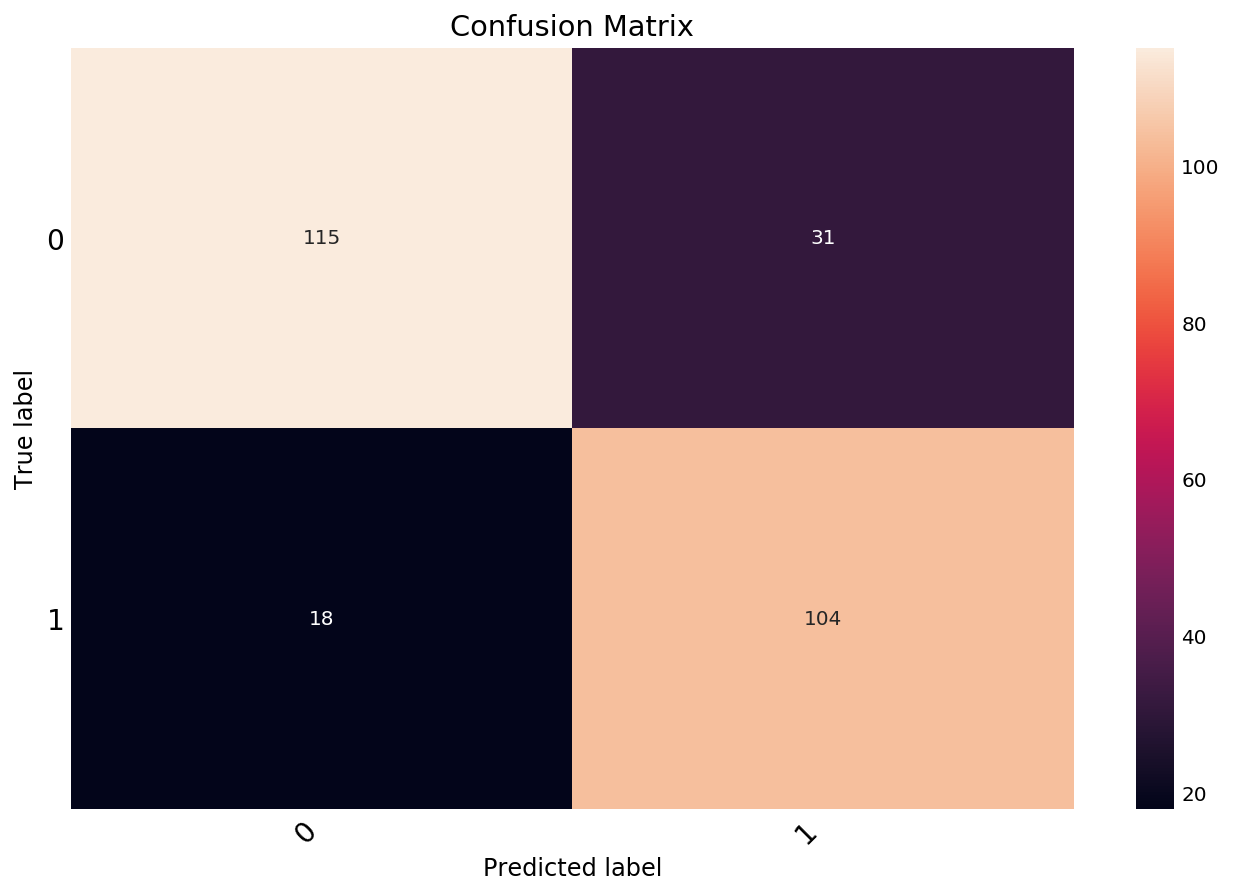

In [25]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(binary=True)),
    ('clf', LogisticRegression(random_state=0)),
])
train_test_and_evaluate(pipeline,x_train,y_train,x_val,y_val)

In [26]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print( "null accuracy: {0:.2f}%".format(null_accuracy*100) )
    print( "accuracy score: {0:.2f}%".format(accuracy*100)    )
    if accuracy > null_accuracy:
        print( "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100) )
    elif accuracy == null_accuracy:
        print( "model has the same accuracy with the null accuracy" )
    else:
        print( "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100) ) 
    print( "train and test time: {0:.2f}s".format(train_test_time) )
    print( "-"*80 )
    return accuracy, train_test_time

## Realizamos una comparativa rápida de modelos para poder jugar un poco con los mas prometedores

In [27]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from time import time


parameters = {
    'hidden_layer_sizes': [(256,), (512,), (32, 64, 32,)],
    'tol' : [0.01,0.001]
}


names = ["Logistic Regression","Logistic Regression CV", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LogisticRegressionCV(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = list( zip(names,classifiers) )

tfidf_vec = TfidfVectorizer()
count_vec = CountVectorizer()

vectorizers = {
    'tfidf' : tfidf_vec,
    'count' : count_vec
}

def classifier_comparator(
        vectorizers = vectorizers , 
        max_features  = 17000       , 
        stop_words    = None        , 
        ngram_range   = (1, 5)      ,
        binary        = True        ,
        min_df        = 3           ,
        max_df        = 0.90        ,
        classifier    = zipped_clf ) : 
    result = []

    for vectName, vectorizer in vectorizers.items():
        
        vectorizer.set_params(
            stop_words   = stop_words  , 
            max_features = max_features  , 
            ngram_range  = ngram_range ,
            binary       = binary      ,
            min_df       = min_df      ,
            max_df       = max_df
        )
        
        for ( n , c ) in classifier:
            checker_pipeline = Pipeline([
                ( 'vectorizer', vectorizer ),
                ( 'classifier', c          )
            ])
            print( "Validation result for {} ({})".format(n,vectName) )
            print( c )
            clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train,y_train,x_val,y_val)
            result.append(( "{} ({})".format(n,vectName) ,clf_accuracy,tt_time))
    
    return result

trigram_result = classifier_comparator(
    max_features  = 170000    , 
    ngram_range = (1, 5)
)

Validation result for Logistic Regression (tfidf)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 54.48%
accuracy score: 80.60%
model is 26.12% more accurate than null accuracy
train and test time: 2.58s
--------------------------------------------------------------------------------
Validation result for Logistic Regression CV (tfidf)
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)
null accuracy: 54.48%
accuracy score: 83.58%
model is 29.10% more accurate than null accuracy
train and test time: 3.61s
------------------------

/home/luis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 54.48%
accuracy score: 79.10%
model is 24.63% more accurate than null accuracy
train and test time: 2.80s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive (tfidf)
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


/home/luis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 54.48%
accuracy score: 85.07%
model is 30.60% more accurate than null accuracy
train and test time: 2.74s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid (tfidf)
NearestCentroid(metric='euclidean', shrink_threshold=None)
null accuracy: 54.48%
accuracy score: 80.60%
model is 26.12% more accurate than null accuracy
train and test time: 3.32s
--------------------------------------------------------------------------------
Validation result for Logistic Regression (count)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 54.48%
accuracy score: 84.33%
model is 29.85% more accurate than null accuracy
train and test time: 3.24s
------------------------------------------------------

/home/luis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 54.48%
accuracy score: 79.10%
model is 24.63% more accurate than null accuracy
train and test time: 2.83s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive (count)
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


/home/luis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 54.48%
accuracy score: 83.21%
model is 28.73% more accurate than null accuracy
train and test time: 3.07s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid (count)
NearestCentroid(metric='euclidean', shrink_threshold=None)
null accuracy: 54.48%
accuracy score: 63.81%
model is 9.33% more accurate than null accuracy
train and test time: 2.87s
--------------------------------------------------------------------------------


In [28]:
comparison = pd.DataFrame(list(trigram_result), columns=['model','validation_accuracy','train_and_test'])
comparison.sort_values(['validation_accuracy', 'train_and_test'], ascending=[0, 1])

,model,validation_accuracy,train_and_test
9,Passive-Aggresive (tfidf),0.850746,2.738898
12,Logistic Regression CV (count),0.847015,4.383353
11,Logistic Regression (count),0.843284,3.239680
13,Linear SVC (count),0.839552,3.087263
2,Linear SVC (tfidf),0.835821,2.588453
1,Logistic Regression CV (tfidf),0.835821,3.613936
20,Passive-Aggresive (count),0.832090,3.073834
6,Ridge Classifier (tfidf),0.824627,3.024333
3,LinearSVC with L1-based feature selection (tfidf),0.809701,2.613655
0,Logistic Regression (tfidf),0.805970,2.583764


## Luego tratamos de elegir los mejores hiper parametros utilizanos un GridSearchCV

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])


{'clf__C': 2,
 'clf__multi_class': 'ovr',
 'clf__penalty': 'l2',
 'clf__tol': 0.01,
 'vect__binary': True,
 'vect__max_df': 0.9,
 'vect__max_features': 17000,
 'vect__min_df': 3,
 'vect__ngram_range': (1, 1),
 'vect__strip_accents': 'unicode'}

null accuracy: 54.48%
accuracy score: 80.60%
model is 26.12% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                 123                  23
positive                  29                  93
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.81      0.84      0.83       146
   positive       0.80      0.76      0.78       122

avg / total       0.81      0.81      0.81       268



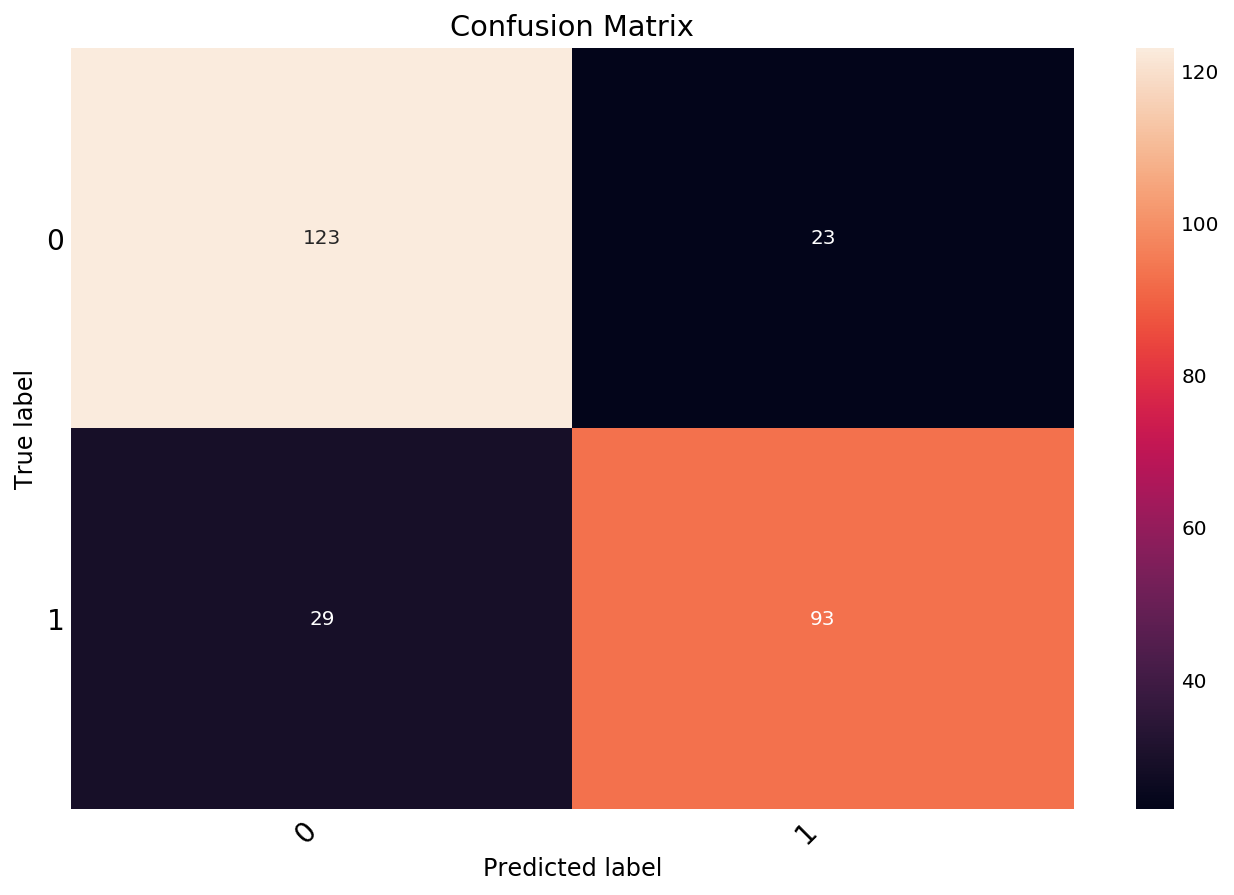

In [42]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define 10 fold cross-validation
cv = KFold(n_splits=5)

linearscv_params = {
    'vect__strip_accents' : [ 'unicode'],
    'vect__ngram_range'   : [ (1, 1), (1, 3), (1, 5)],
    'vect__max_features'  : [ 17000 ]       , 
    #'vect__stop_words'    : [ 'english' ]       , 
    'vect__binary'        : [ True ]        ,
    'vect__min_df'        : [ 3    ]        ,
    'vect__max_df'        : [ 0.90  ]      ,
    'clf__tol'            : [ 1e-2     ],
    'clf__C'              : [ 2        ],
    'clf__multi_class'    : [ 'ovr'    ], 
    'clf__penalty'        : [ 'l2'     ]
}

estimator = LinearSVC() # {'clf__C': 2, 'clf__multi_class': 'ovr', 'clf__penalty': 'l2','clf__tol': 0.01}

pipeline = Pipeline([
  ( 'vect' , CountVectorizer() ) , 
  ( 'feat' , SelectFromModel(LinearSVC(penalty="l1", dual=False)) ),
  ( 'clf'  , estimator )
])

print(estimator.get_params().keys())

# Define the model & input the hyperparameter dictionary objects into the GridSearchCV function
svm_model = GridSearchCV(pipeline, param_grid=linearscv_params, scoring='roc_auc', cv=cv)

# Test the SVC estimator with its grid of hyperparamters on the training set
svm_model.fit(x_train,y_train)

display( svm_model.best_params_ )

train_test_and_evaluate(pipeline,x_train,y_train,x_val,y_val)

### utilizamos algunos valores para entrenar un modelo y poder generar los valores de entrenamiento

null accuracy: 54.48%
accuracy score: 86.19%
model is 31.72% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                 126                  20
positive                  17                 105
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.88      0.86      0.87       146
   positive       0.84      0.86      0.85       122

avg / total       0.86      0.86      0.86       268



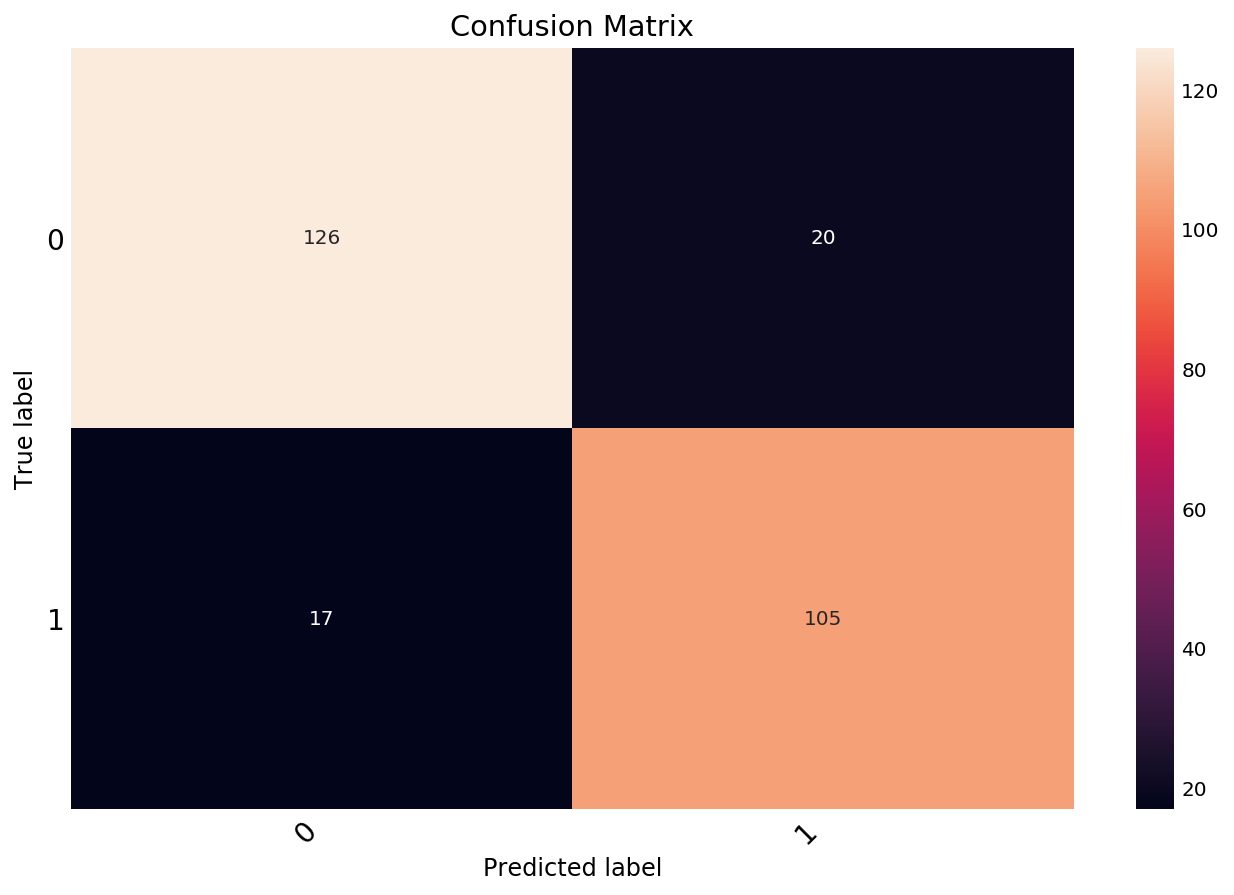

In [30]:
vectorizer = TfidfVectorizer(
        binary=True,
        min_df=5,
        max_df=0.95,
        ngram_range=(1, 2)       
)

pipeline = Pipeline([
    ('vect', vectorizer),
    ('clf', LinearSVC(random_state=0)),
])
train_test_and_evaluate(pipeline,x_train,y_train,x_val,y_val)

In [31]:
import glob
import errno

myFiles = []
myPred = []

path = 'review_polarity_competition/test_reviews_sentoken/*.txt'
files = glob.glob(path)
index = 0
for name in files:
    try:
        with open(name) as f:
            y_pred = pipeline.predict(f)
            myFiles.append(name)
            myPred.append(str(y_pred).replace("[", "").replace("]", ""))
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise

In [32]:
df = pd.DataFrame(data={"Id": myFiles, "Category": myPred})
df['Id'] = df['Id'].str.replace('review_polarity_competition/test_reviews_sentoken/','')
df = df[["Id", "Category"]]
df = df.sort_values(['Id'], ascending=[1])
df.head(20)

,Id,Category
429,0.txt,0
302,1.txt,1
187,10.txt,0
458,100.txt,1
236,101.txt,0
447,102.txt,0
319,103.txt,1
431,104.txt,0
408,105.txt,0
68,106.txt,0


In [33]:
df.to_csv("./file.csv", sep=',',index=False)